In [5]:
import findspark
findspark.init()
import pyspark
import re

import numpy as np
import scipy.sparse as sps
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '8')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]

4220 yul817


In [7]:
sc = pyspark.SparkContext(appName="Project 2", master='spark://polyp1:7077',conf = config )

In [4]:
train_path='train.csv'
#test_path='test.csv'

train_rdd = sc.textFile(train_path).cache()
#test_rdd = sc.textFile(test_path).cache()

In [5]:
print train_rdd.take(3)

print "\nnumber of records:"
print train_rdd.count()

[u'date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster', u'2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1', u'2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1']
37670294


In [5]:
#1.How many features are in the dataset?

train_header = train_rdd.first()
print "feature list:"
for i,header in enumerate(train_header.split(",")):
    print i, " : ", header

noheader_train_rdd = train_rdd.filter(lambda line: line != train_header).cache()
print "\ntrain_rdd without header:"
print noheader_train_rdd.take(3)

feature list:
0  :  date_time
1  :  site_name
2  :  posa_continent
3  :  user_location_country
4  :  user_location_region
5  :  user_location_city
6  :  orig_destination_distance
7  :  user_id
8  :  is_mobile
9  :  is_package
10  :  channel
11  :  srch_ci
12  :  srch_co
13  :  srch_adults_cnt
14  :  srch_children_cnt
15  :  srch_rm_cnt
16  :  srch_destination_id
17  :  srch_destination_type_id
18  :  is_booking
19  :  cnt
20  :  hotel_continent
21  :  hotel_country
22  :  hotel_market
23  :  hotel_cluster

train_rdd without header:
[u'2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1', u'2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1', u'2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1']


In [6]:
def StringtoList(line):
    data = line.split(",")
    return data

list_train_rdd = noheader_train_rdd.map(StringtoList).cache()
print list_train_rdd.take(5)

[[u'2014-08-11 07:46:59', u'2', u'3', u'66', u'348', u'48862', u'2234.2641', u'12', u'0', u'1', u'9', u'2014-08-27', u'2014-08-31', u'2', u'0', u'1', u'8250', u'1', u'0', u'3', u'2', u'50', u'628', u'1'], [u'2014-08-11 08:22:12', u'2', u'3', u'66', u'348', u'48862', u'2234.2641', u'12', u'0', u'1', u'9', u'2014-08-29', u'2014-09-02', u'2', u'0', u'1', u'8250', u'1', u'1', u'1', u'2', u'50', u'628', u'1'], [u'2014-08-11 08:24:33', u'2', u'3', u'66', u'348', u'48862', u'2234.2641', u'12', u'0', u'0', u'9', u'2014-08-29', u'2014-09-02', u'2', u'0', u'1', u'8250', u'1', u'0', u'1', u'2', u'50', u'628', u'1'], [u'2014-08-09 18:05:16', u'2', u'3', u'66', u'442', u'35390', u'913.1932', u'93', u'0', u'0', u'3', u'2014-11-23', u'2014-11-28', u'2', u'0', u'1', u'14984', u'1', u'0', u'1', u'2', u'50', u'1457', u'80'], [u'2014-08-09 18:08:18', u'2', u'3', u'66', u'442', u'35390', u'913.6259', u'93', u'0', u'0', u'3', u'2014-11-23', u'2014-11-28', u'2', u'0', u'1', u'14984', u'1', u'0', u'1', u'2',

In [7]:
#2.Creating the histogram showing the location country of users.
def user_location_country(line):
    data = line.split(",")
    return (data[3], 1)

q2_res = noheader_train_rdd.map(user_location_country).reduceByKey(lambda a,b : a + b).sortByKey().cache()

In [8]:
user_location_country_X = []
user_location_country_Y = []

for line in q2_res.collect():
    user_location_country_X.append(line[0])
    user_location_country_Y.append(line[1])

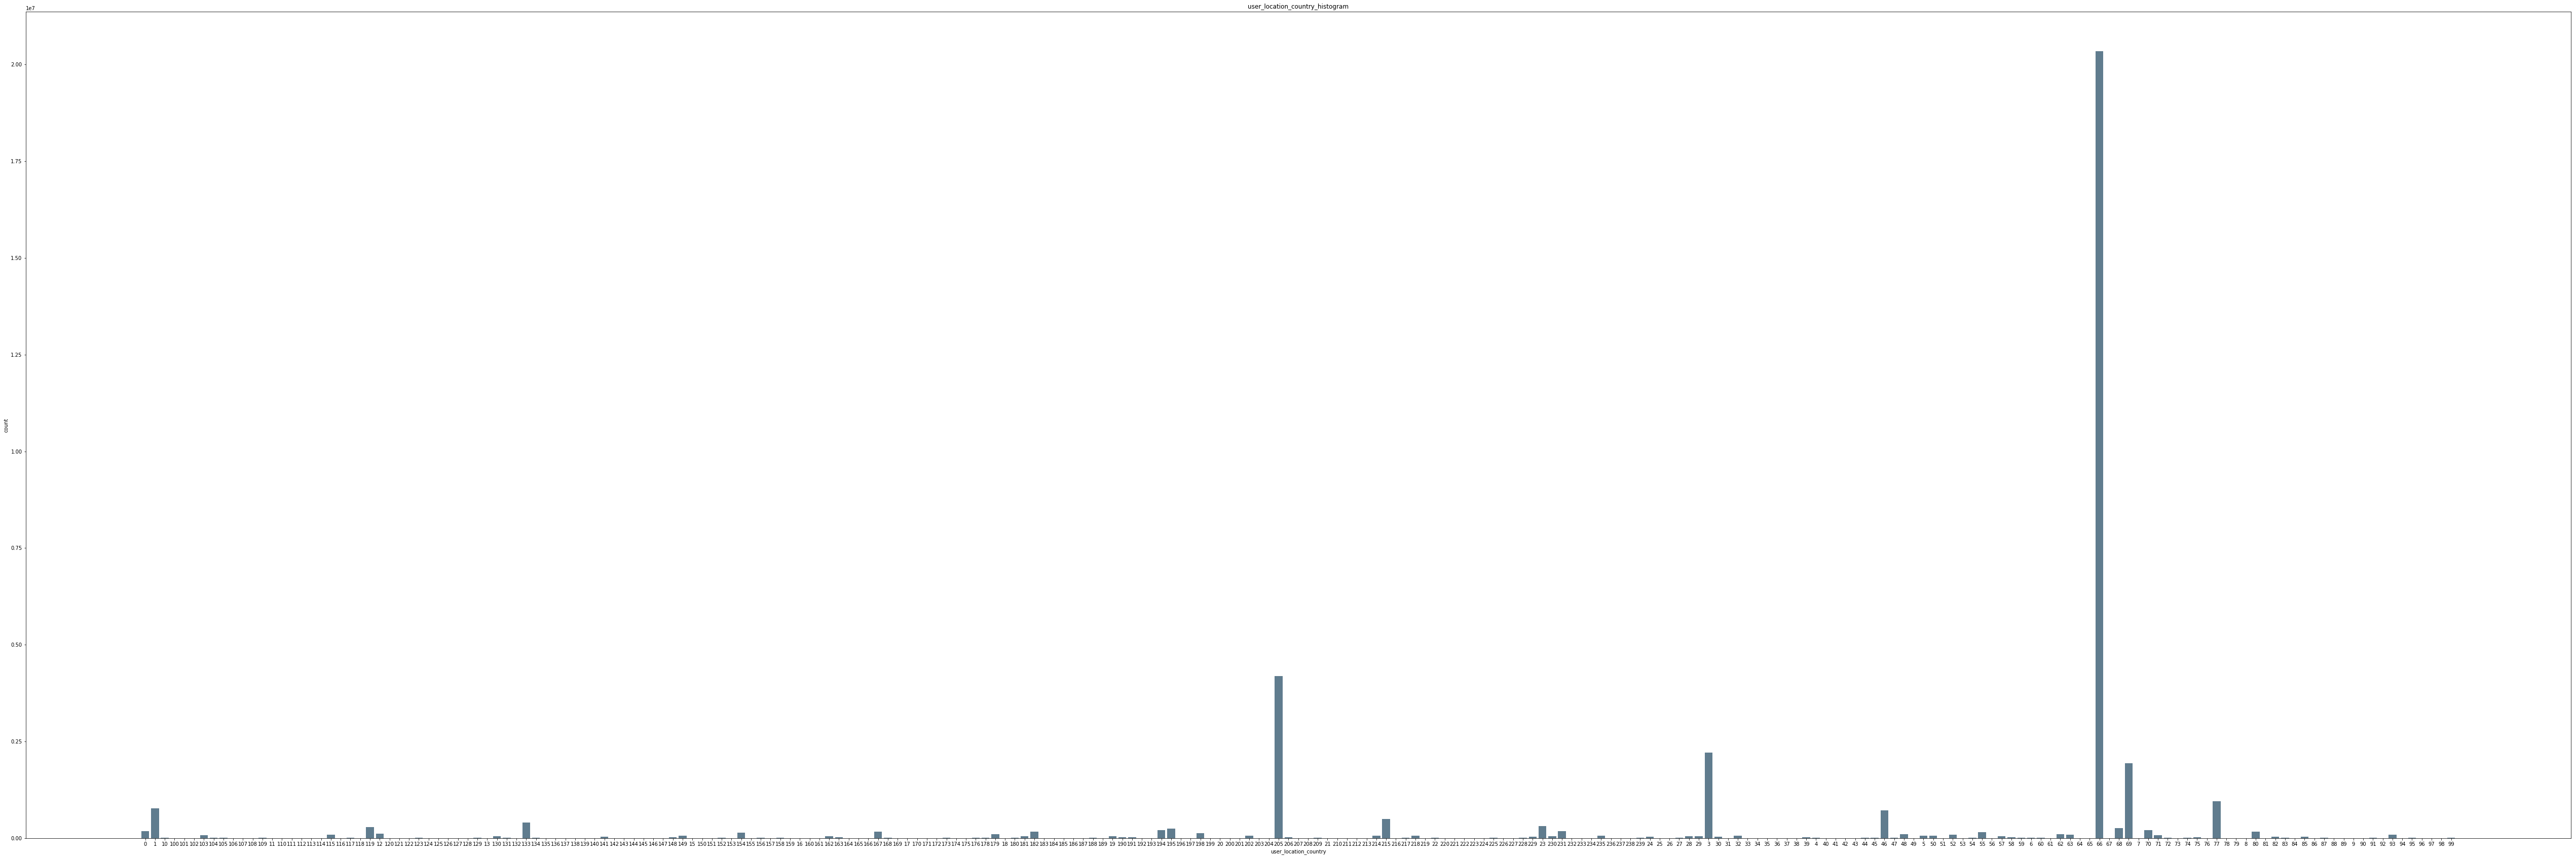

In [9]:
plt.figure(figsize=(90,30))
plt.bar(user_location_country_X,user_location_country_Y,color="#607c8e")
plt.xlabel("user_location_country")
plt.ylabel("count")
plt.title("user_location_country_histogram")
plt.show()

In [8]:
#3.Creating the histogram showing the location country of hotel.
def user_destination_country(line):
    data = line.split(",")
    return (data[16], 1)

q3_res = noheader_train_rdd.map(user_destination_country).reduceByKey(lambda a,b : a + b).map(lambda line: (int(-line[1]), line[0])).sortByKey().cache()

In [11]:
user_destination_country_X = []
user_destination_country_Y = []

for line in q3_res.collect():
    user_destination_country_X.append(line[1])
    user_destination_country_Y.append(-line[0])

X = user_destination_country_X[:100]
Y = user_destination_country_Y[:100]

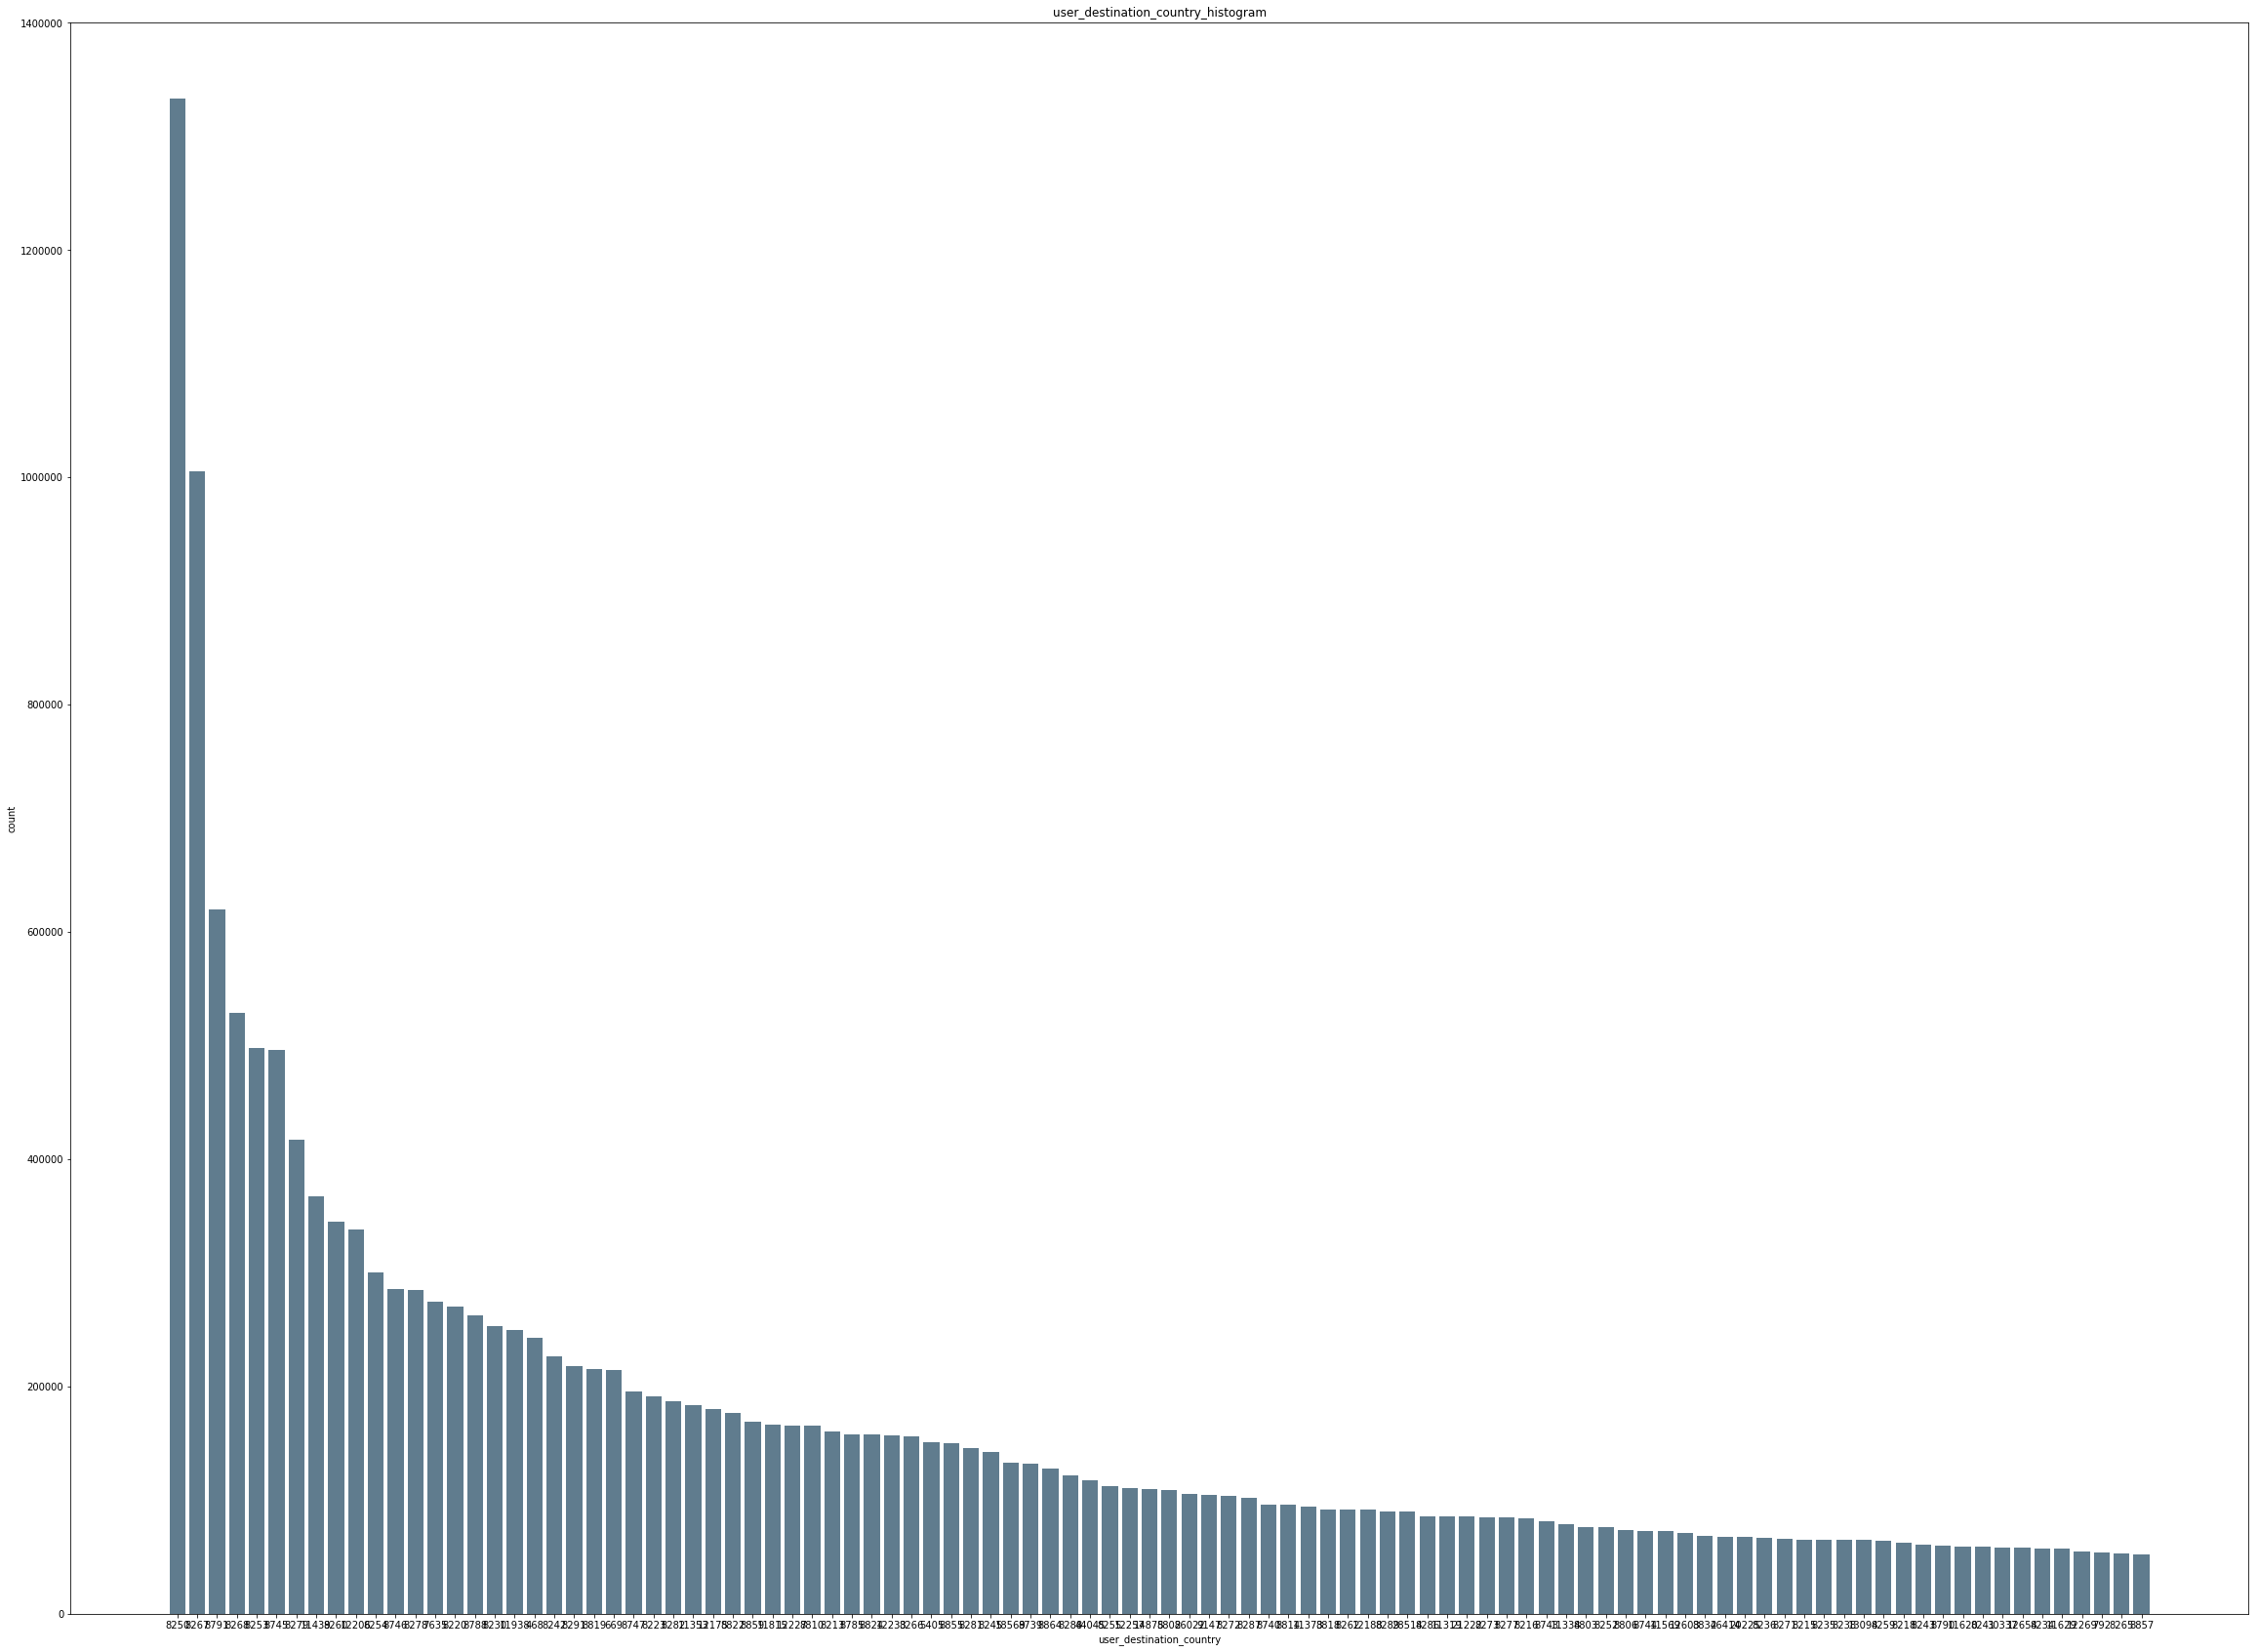

In [14]:
plt.figure(figsize=(40,30))
plt.bar(X,Y,color="#607c8e")
plt.xlabel("user_destination_country")
plt.ylabel("count")
plt.title("user_destination_country_histogram")
plt.show()

In [22]:
print "most popular destination is: ", user_destination_country_X[user_destination_country_Y.index(max(user_destination_country_Y))]
print "the count of most popular destination is: ", max(user_destination_country_Y)

most popular destination is:  8250
the count of most popular destination is:  1333657


In [12]:
#4. For the country with the highest number of users, creating a histogram 
#showing the popularity of top 10 possible destinations.

In [7]:
q4_tmp = list_train_rdd.filter(lambda line: line[3] == '66').map(lambda line: (line[16],1)).reduceByKey(lambda a,b : a+b)

In [8]:
q4_res = q4_tmp.map(lambda line: (-line[1], line[0])).sortByKey().cache()

In [9]:
res_q4_X = []
res_q4_Y = []

for line in q4_res.collect():
    res_q4_Y.append(int(-line[0]))
    res_q4_X.append(str(line[1]))

In [10]:
X = res_q4_X[:10]
Y = res_q4_Y[:10]
print X
print Y

['8250', '8267', '8791', '8268', '11439', '8279', '12206', '8278', '8260', '11938']
[890819, 540765, 506246, 341408, 304724, 292629, 233020, 224588, 211290, 199769]


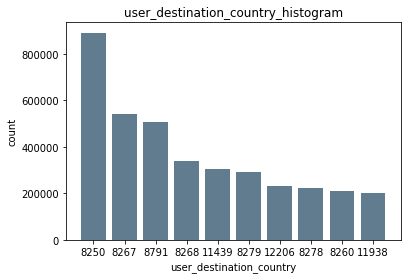

In [11]:
plt.bar(X,Y,color="#607c8e")
plt.xlabel("user_destination_country")
plt.ylabel("count")
plt.title("user_destination_country_histogram")
plt.show()

In [15]:
#5.find most frequent combination of user_location_country, user_location_region, user_location_city

from pyspark.mllib.fpm import FPGrowth
tmp_5 = list_train_rdd.map(lambda line: [line[3], line[4], line[5]])
res_q5 = tmp_5.map(lambda x: list(set(x))).cache()
print res_q5.take(3)

[[u'48862', u'348', u'66'], [u'48862', u'348', u'66'], [u'48862', u'348', u'66']]


In [19]:
model = FPGrowth.train(res_q5, minSupport=0.01, numPartitions=10)
result = model.freqItemsets().sortBy(lambda x: x[1], False).collect()
result.sort(key=lambda tup: tup[1], reverse=True)
print "user country, region, and city that are frequently used together:"
for r in result:
    print r

user country, region, and city that are frequently used together:
FreqItemset(items=[u'66'], freq=20362971)
FreqItemset(items=[u'205'], freq=4190220)
FreqItemset(items=[u'174'], freq=4134347)
FreqItemset(items=[u'174', u'66'], freq=4125139)
FreqItemset(items=[u'3'], freq=2225325)
FreqItemset(items=[u'69'], freq=1948039)
FreqItemset(items=[u'348'], freq=1873415)
FreqItemset(items=[u'348', u'66'], freq=1873318)
FreqItemset(items=[u'354'], freq=1708231)
FreqItemset(items=[u'354', u'205'], freq=1708195)
FreqItemset(items=[u'442'], freq=1432740)
FreqItemset(items=[u'442', u'66'], freq=1432740)
FreqItemset(items=[u'220'], freq=1365794)
FreqItemset(items=[u'220', u'66'], freq=1356506)
FreqItemset(items=[u'50'], freq=1112852)
FreqItemset(items=[u'462'], freq=1041898)
FreqItemset(items=[u'50', u'3'], freq=1021503)
FreqItemset(items=[u'77'], freq=990831)
FreqItemset(items=[u'462', u'66'], freq=946399)
FreqItemset(items=[u'155'], freq=857289)
FreqItemset(items=[u'155', u'205'], freq=854476)
FreqI

In [8]:
# 6. use SVD to reduce the data volume
def getvalue(value):
    if value == '':
        return 0.0
    else:
        return float(value)
    
def parse(line):
    res = np.zeros((15),np.float)
    res[0] = getvalue(line[1]) #site_name
    res[1] = getvalue(line[2]) #posa_continent
    res[2] = getvalue(line[3]) #user_location_country
    res[3] = getvalue(line[4]) #user_location_region
    res[4] = getvalue(line[5]) #user_location_city
    res[5] = getvalue(line[6]) #orig_destination_distance
    res[6] = getvalue(line[8]) #is_mobile
    res[7] = getvalue(line[9]) #is_package
    res[8] = getvalue(line[13]) #srch_adults_cnt
    res[9] = getvalue(line[14]) #srch_children_cnt
    res[10] = getvalue(line[16]) #srch_destination_id
    res[11] = getvalue(line[17]) #srch_destination_type_id
    res[12] = getvalue(line[20]) #hotel_continent
    res[13] = getvalue(line[21]) #hotel_country
    res[14] = getvalue(line[13]) #hotel_cluster
    is_booking = getvalue(line[18])
    return is_booking, res

parsed_data = list_train_rdd.map(parse).cache()
print parsed_data.take(5)

[(0.0, array([2.0000000e+00, 3.0000000e+00, 6.6000000e+01, 3.4800000e+02,
       4.8862000e+04, 2.2342641e+03, 0.0000000e+00, 1.0000000e+00,
       2.0000000e+00, 0.0000000e+00, 8.2500000e+03, 1.0000000e+00,
       2.0000000e+00, 5.0000000e+01, 2.0000000e+00])), (1.0, array([2.0000000e+00, 3.0000000e+00, 6.6000000e+01, 3.4800000e+02,
       4.8862000e+04, 2.2342641e+03, 0.0000000e+00, 1.0000000e+00,
       2.0000000e+00, 0.0000000e+00, 8.2500000e+03, 1.0000000e+00,
       2.0000000e+00, 5.0000000e+01, 2.0000000e+00])), (0.0, array([2.0000000e+00, 3.0000000e+00, 6.6000000e+01, 3.4800000e+02,
       4.8862000e+04, 2.2342641e+03, 0.0000000e+00, 0.0000000e+00,
       2.0000000e+00, 0.0000000e+00, 8.2500000e+03, 1.0000000e+00,
       2.0000000e+00, 5.0000000e+01, 2.0000000e+00])), (0.0, array([2.000000e+00, 3.000000e+00, 6.600000e+01, 4.420000e+02,
       3.539000e+04, 9.131932e+02, 0.000000e+00, 0.000000e+00,
       2.000000e+00, 0.000000e+00, 1.498400e+04, 1.000000e+00,
       2.000000e+0

In [9]:
avg = parsed_data.map(lambda kv: kv[1]).reduce(lambda x,y: x+y)/37670294
print "avg list of all record: ", avg

tmp_cleanedData = parsed_data.map(lambda kv: (kv[0], kv[1]-avg)).cache()
print "\ndata after 1st cleaning: \n", tmp_cleanedData.take(2)

avg list of all record:  [9.79527107e+00 2.68047295e+00 8.61087997e+01 3.08406004e+02
 2.77530440e+04 1.26275624e+03 1.34926502e-01 2.48904216e-01
 2.02429578e+00 3.32122149e-01 1.44410902e+04 2.58227985e+00
 3.15630470e+00 8.12968495e+01 2.02429578e+00]

data after 1st cleaning: 
[(0.0, array([-7.79527107e+00,  3.19527052e-01, -2.01087997e+01,  3.95939964e+01,
        2.11089560e+04,  9.71507856e+02, -1.34926502e-01,  7.51095784e-01,
       -2.42957753e-02, -3.32122149e-01, -6.19109016e+03, -1.58227985e+00,
       -1.15630470e+00, -3.12968495e+01, -2.42957753e-02])), (1.0, array([-7.79527107e+00,  3.19527052e-01, -2.01087997e+01,  3.95939964e+01,
        2.11089560e+04,  9.71507856e+02, -1.34926502e-01,  7.51095784e-01,
       -2.42957753e-02, -3.32122149e-01, -6.19109016e+03, -1.58227985e+00,
       -1.15630470e+00, -3.12968495e+01, -2.42957753e-02]))]


In [10]:
maximum = tmp_cleanedData.map(lambda kv: np.abs(kv[1])).reduce(lambda x,y:  np.maximum(x,y) )
print "max list of all record: ", maximum

cleanedData = tmp_cleanedData.map(lambda kv: (kv[0], kv[1]/maximum )).cache()
print "\ndata after 2rd cleaning: \n", cleanedData.take(5)

max list of all record:  [4.32047289e+01 2.68047295e+00 1.52891200e+02 7.18593996e+02
 2.87549560e+04 1.11451460e+04 8.65073498e-01 7.51095784e-01
 6.97570422e+00 8.66787785e+00 5.06659098e+04 6.41772015e+00
 3.15630470e+00 1.30703150e+02 6.97570422e+00]

data after 2rd cleaning: 
[(0.0, array([-0.18042634,  0.11920548, -0.13152359,  0.05509926,  0.73409801,
        0.0871687 , -0.15597114,  1.        , -0.00348291, -0.03831643,
       -0.12219439, -0.24654859, -0.36634762, -0.23944985, -0.00348291])), (1.0, array([-0.18042634,  0.11920548, -0.13152359,  0.05509926,  0.73409801,
        0.0871687 , -0.15597114,  1.        , -0.00348291, -0.03831643,
       -0.12219439, -0.24654859, -0.36634762, -0.23944985, -0.00348291])), (0.0, array([-0.18042634,  0.11920548, -0.13152359,  0.05509926,  0.73409801,
        0.0871687 , -0.15597114, -0.33138812, -0.00348291, -0.03831643,
       -0.12219439, -0.24654859, -0.36634762, -0.23944985, -0.00348291])), (0.0, array([-0.18042634,  0.11920548, -0.

In [12]:
from pyspark.mllib.linalg.distributed import RowMatrix
svdData = cleanedData.map(lambda line: line[1]).cache()
mat = RowMatrix(svdData)
svd = mat.computeSVD(3, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.

print "vector:\n", s  # vector
print '\nRDD:\n', U  # RDD
print '\nmatrix:\n', V  # matrix

vector:
[3714.1707021278557,3615.543263337093,3390.5044987424476]

RDD:

matrix:
DenseMatrix([[-0.11512817, -0.02693295,  0.1614292 ],
             [ 0.15609232,  0.06286906, -0.1653271 ],
             [ 0.03079575,  0.14879247,  0.02890622],
             [-0.03924558,  0.08139008,  0.00918567],
             [-0.11190942,  0.97496819,  0.08324958],
             [-0.02568198,  0.00538556,  0.03539412],
             [-0.03347611,  0.00460267, -0.081383  ],
             [-0.79938484, -0.03805279, -0.5362757 ],
             [ 0.00630437,  0.00380339, -0.00151202],
             [ 0.00827444,  0.00332792, -0.00596565],
             [ 0.0544865 ,  0.00331322,  0.07019398],
             [ 0.16432706,  0.01567218,  0.10215317],
             [-0.49733893, -0.10507468,  0.63948975],
             [-0.17060455, -0.05621474,  0.46791004],
             [ 0.00630437,  0.00380339, -0.00151202]])


In [14]:
reducedData = cleanedData.map(lambda line: (line[0], line[1].dot(V.toArray()))).cache()
print "data after SVD reduction: \n", reducedData.take(5)

data after SVD reduction: 
[(0.0, array([-0.66987159,  0.7222212 , -0.89135383])), (1.0, array([-0.66987159,  0.7222212 , -0.89135383])), (0.0, array([ 0.39441989,  0.77288423, -0.17736274])), (0.0, array([ 0.45200284,  0.32655007, -0.21003037])), (0.0, array([ 0.45200185,  0.32655028, -0.210029  ]))]


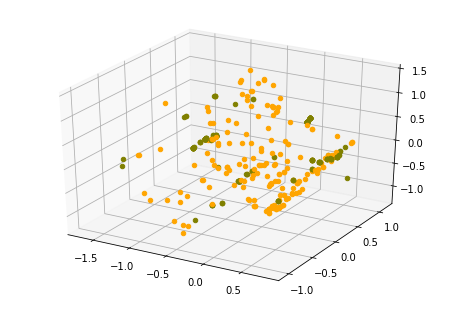

In [29]:
#7.plot 200 records in booked / unbooked record.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.show()
fig = plt.figure()
ax = Axes3D(fig)

bookedData = reducedData.filter(lambda line: line[0] == 1.0).cache()
unbookedData = reducedData.filter(lambda line: line[0] == 0.0).cache()

for line in bookedData.take(200):
    ax.scatter( line[1][0], line[1][1], line[1][2], c = 'orange' )
for line in unbookedData.take(200):
    ax.scatter( line[1][0], line[1][1], line[1][2], c = 'olive' )

In [31]:
# 8. training random forest model
from pyspark.mllib.regression import LabeledPoint

def labeled(line):
    return LabeledPoint(line[0] ,line[1])
    
labledData = reducedData.map(labeled).cache()
print "training data with lables:"
print labledData.take(5)

training data with lables:
[LabeledPoint(0.0, [-0.669871586530866,0.722221202971779,-0.8913538334812277]), LabeledPoint(1.0, [-0.669871586530866,0.722221202971779,-0.8913538334812277]), LabeledPoint(0.0, [0.39441989111388887,0.7728842314604552,-0.17736274488067222]), LabeledPoint(0.0, [0.45200284493748855,0.3265500677729557,-0.21003037349352469]), LabeledPoint(0.0, [0.4520018478584038,0.3265502768624807,-0.21002899934953836])]


In [32]:
#split the training rdd into training and validation sets by 70/30
training, validation = labledData.randomSplit(weights=[0.7, 0.3])

num_training = float(training.count())
num_validation = float(validation.count())
print "# of training records : ", num_training
print "# of validation records : ", num_validation

# of training records :  26370948.0
# of validation records :  11299345.0


In [35]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

randomtree_model = RandomForest.trainClassifier(training, numClasses=2, categoricalFeaturesInfo={},\
                                     numTrees=5, featureSubsetStrategy="all",\
                                     impurity='entropy', maxDepth=10, maxBins=64)

In [37]:
predictions = randomtree_model.predict(validation.map(lambda x: x.features))
labelsAndPredictions = validation.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(validation.count())
print('Test Error = ' + str(testErr))

Test Error = 0.079619836371


In [38]:
print('Learned classification forest model:')
print(randomtree_model.toDebugString())

Learned classification forest model:
TreeEnsembleModel classifier with 5 trees

  Tree 0:
    If (feature 0 <= -0.5164158777843412)
     If (feature 0 <= -0.7335637236227132)
      If (feature 0 <= -1.3491617393063013)
       If (feature 0 <= -1.4688991137862364)
        If (feature 2 <= 0.4603733724763985)
         If (feature 2 <= 0.17861317466938673)
          If (feature 1 <= 0.45172705627571885)
           If (feature 1 <= 0.2545077703532618)
            If (feature 1 <= -0.45829104186447567)
             If (feature 1 <= -0.49624899702190334)
              Predict: 0.0
             Else (feature 1 > -0.49624899702190334)
              Predict: 0.0
            Else (feature 1 > -0.45829104186447567)
             If (feature 2 <= 0.0745553799954435)
              Predict: 0.0
             Else (feature 2 > 0.0745553799954435)
              Predict: 0.0
           Else (feature 1 > 0.2545077703532618)
            If (feature 1 <= 0.3552676999022579)
             If (feature 2 <= -0.

In [7]:
# 9.recommendation - Collaborative Filtering
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

ratings = list_train_rdd.map(lambda l: Rating(int(l[7]), int(l[16]), float(l[18]))).cache()

rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

In [8]:
# 10 recommendations:
user5 = ratings.filter(lambda p: p[0] == 5).map(lambda p: (p[0], p[1])).cache()
user5_predictions = model.predictAll(user5).cache()#.map(lambda p: (p[2], (p[0], p[1]))).sortByKey()#.filter(lambda p: p[2] == 1.0)
print "\nhotel predict for user 5 is:\n"
print user5_predictions.take(10)


hotel predict for user 0 is:

[(0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281)), (0.10691538251669484, (5, 8281))]


In [51]:
# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1])).cache()
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2])).cache()
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.0416327045266


In [18]:
#recommendation
hotel_list = []
def findhotel(line):
    hotelid = int(line[16])
    if hotelid not in hotel_list:
        hotel_list.append(hotelid)
    return hotelid
hotel = list_train_rdd.map(findhotel).cache()
print "hotel list:"
print hotel_list
print hotel.take(10)

hotel list:
[]
[8250, 8250, 8250, 14984, 14984, 14984, 8267, 8267, 8267, 8267]


In [ ]:
allMoviesRDD = sc.parallelize( movieBias.keys())
print allMoviesRDD.take(10)

predictForMe = allMoviesRDD.map(lambda d: (0,d)  )
print predictForMe.take(10)

predForMe = model.predictAll(predictForMe)
print "\n\n"
print predForMe.take(10)

In [ ]:
sc.stop()